# ECE-474 Bayesian ML - Project 1
### Wongee (Freddy) Hong, Myisha Hassan, Lennart Vetter

### Task:
The project is to implement conjugate estimators for the following scenarios:

- Binomial
- Gaussian with known variance (i.e. estimate the mean)
- Gaussian with known mean (i.e. estimate the variance)

You should plot the mean squared error both the ML and conjugate prior estimates, all on one plot, with a legend. For each scenario, choose 2-3 different values for the hyper parameters.

Additionally, for at least one set of hyperparameter per scenario, plot the posterior density as it changes with observations. The easy way to do this is to just plot the pdf a few times, for different #s of observations.


**Stretch Goal #1: Make a movie showing the posterior converge (2 points)**

**Stretch Goal #2: Implement the conjugate prior estimator for the unknown mean and variance case. Plot the pdf as it changes as in the first part. Note this will be a 3-Dim pdf, so use a heatmap or something similar. (3 points)**



In [ ]:
# Imports
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import imageio
from google.colab import files


## 1. Binomial

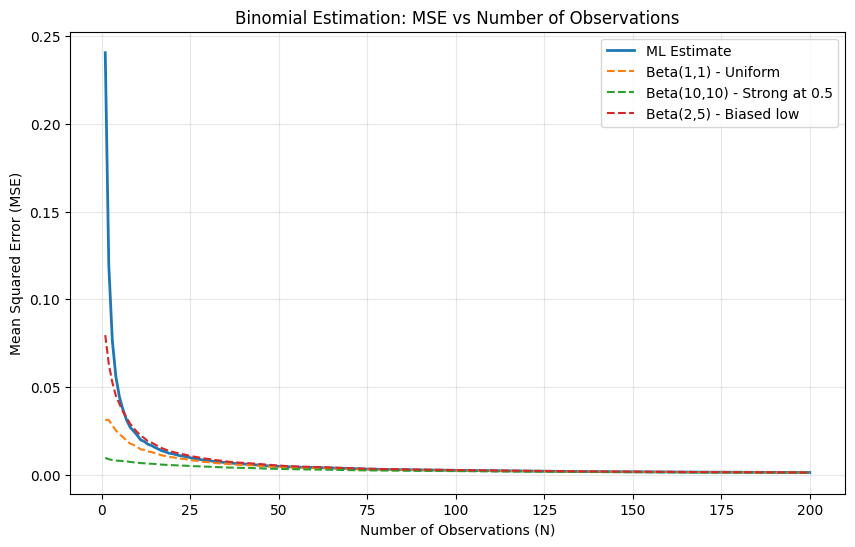

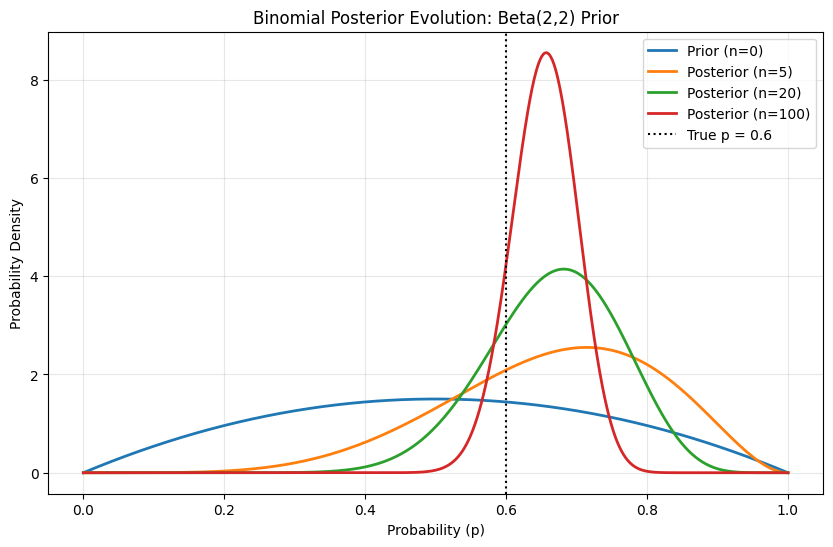

In [ ]:
p_true = 0.6 # Percentage of True

n_max = 200 # maximum number of data points (Bernoulli trials) we will generate in a single experiment
n_values = np.arange(1, n_max + 1) # array of values 1 to 200
n_trials = 1000 # number of times you'll repeat the entire experiment (iteration)

# Hyperparameters for different beta prior distributions
priors = [
    {'alpha': 1, 'beta': 1, 'label': 'Beta(1,1) - Uniform'},
    {'alpha': 10, 'beta': 10, 'label': 'Beta(10,10) - Strong at 0.5'},
    {'alpha': 2, 'beta': 5, 'label': 'Beta(2,5) - Biased low'}
]

# MSE initialization
mse_ml = np.zeros(n_max)
mse_bayesian = [np.zeros(n_max) for _ in priors]

# Trial Loop that runs experiment 1000 times
for trial in range(n_trials):
    # Generate all data with binomial distribution
    data = np.random.binomial(1, p_true, n_max) # Generate 200 Bernoulli trials, each with success probability 0.6
    cumulative_successes = np.cumsum(data) # cumulative sum --> so it will generate array of number of successes among the 200 bernoulli trials

    """
    Example of cumsum
      data = [1, 0, 1, 0, 1]
      cumulative_successes = [1, 1, 2, 2, 3]
    """

    # For each number of observations N
    for i, n in enumerate(n_values):
        """
          For binomial trials, ML = k/n
          where k = number of successes among the n trials
          and n = number of trials
        """
        # Calculates Maximum Likelihood (ML) estimate for true p value
        p_ml = cumulative_successes[i] / n

        # Accumulate squared error between ML estimate and true value of p
        mse_ml[i] += (p_ml - p_true) ** 2

        # Calculate Bayesian Estimate for each of the 3 different priors
        for j, prior in enumerate(priors):

            # Calculating Posterior parameters
            alpha_post = prior['alpha'] + cumulative_successes[i] # posterior alpha = prior alpha + # success
            beta_post = prior['beta'] + (n - cumulative_successes[i]) # posterior delta = prior delta + # failure

            # Bayesian estimate of p = posterior mean of the beta distribution
            p_bayesian = alpha_post / (alpha_post + beta_post)

            # Accumulate squared error between bayesian estimate and true value of p
            mse_bayesian[j][i] += (p_bayesian - p_true) ** 2


# Average over trials to get Mean Squared Error (MSE) for ML and Bayesian estimates
mse_ml /= n_trials
for j in range(len(priors)):
    mse_bayesian[j] /= n_trials


#-------------Plots--------------#

# Plot MSE comparison of ML and Baye estimates against N observations
plt.figure(figsize=(10, 6))
plt.plot(n_values, mse_ml, label='ML Estimate', linewidth=2)
for j, prior in enumerate(priors):
    plt.plot(n_values, mse_bayesian[j], label=prior['label'], linestyle='--')
plt.xlabel('Number of Observations (N)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Binomial Estimation: MSE vs Number of Observations')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot posterior evolution for one prior
alpha_prior, beta_prior = 2, 2
n_obs_list = [0, 5, 20, 100]

plt.figure(figsize=(10, 6))
x = np.linspace(0, 1, 1000)

# Generate new data for posterior evolution plot
data = np.random.binomial(1, p_true, max(n_obs_list))

for n_obs in n_obs_list:
    if n_obs == 0:
        # Prior distribution
        alpha_post = alpha_prior
        beta_post = beta_prior
        label = 'Prior (n=0)'
    else:
        # Posterior distribution
        successes = np.sum(data[:n_obs])
        alpha_post = alpha_prior + successes
        beta_post = beta_prior + n_obs - successes
        label = f'Posterior (n={n_obs})'

    # Calculate and plot PDF
    pdf = stats.beta.pdf(x, alpha_post, beta_post)
    plt.plot(x, pdf, label=label, linewidth=2)

plt.axvline(p_true, color='black', linestyle=':', label=f'True p = {p_true}')
plt.xlabel('Probability (p)')
plt.ylabel('Probability Density')
plt.title('Binomial Posterior Evolution: Beta(2,2) Prior')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Gaussian with known variance

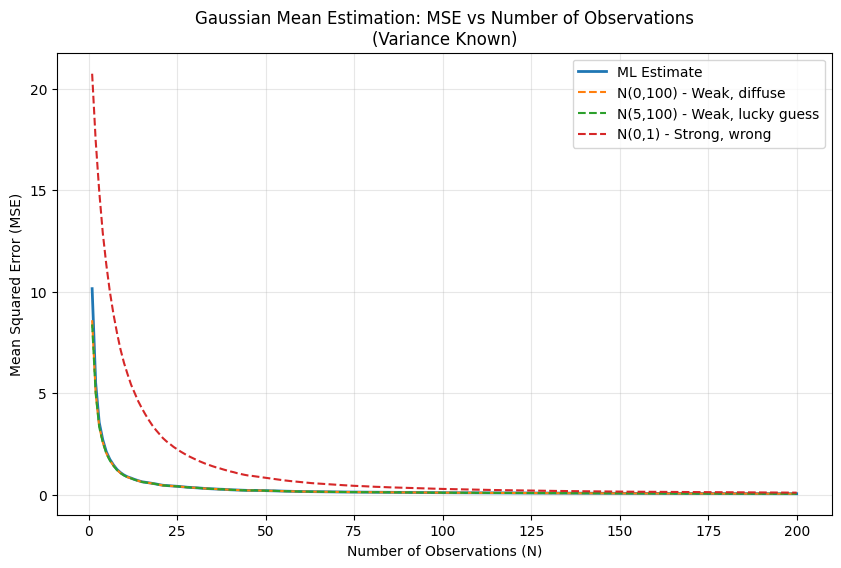

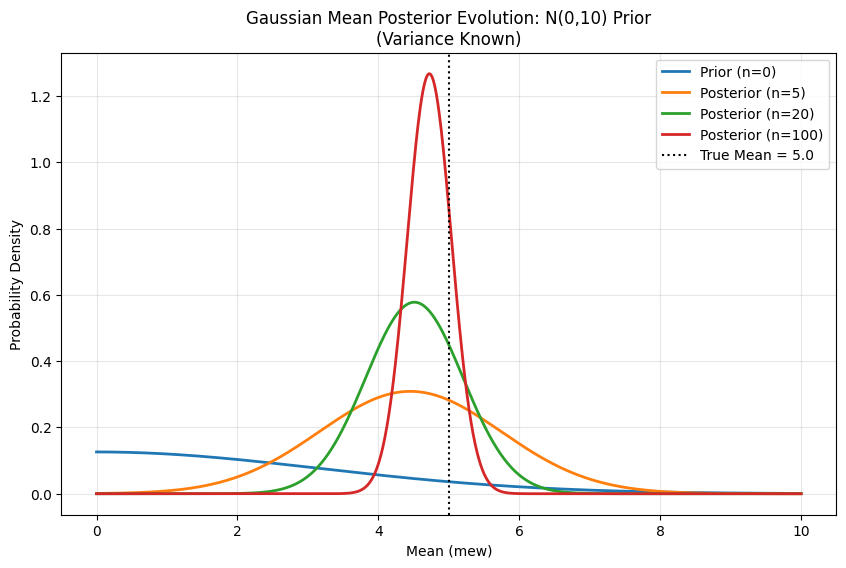

In [ ]:
# True Parameters
true_mean = 5.0 # trying to estimate mean
known_variance = 10.0 # known variance

n_max = 200 # maximum number of data points/trials we will generate in a single experiment
n_values = np.arange(1, n_max + 1) # array of values 1 to 200
n_trials = 1000 # number of times you'll repeat the entire experiment (iteration)

# Hyperparameters for different Gaussian priors on the mean
priors = [
    {'mean': 0, 'variance': 100, 'label': 'N(0,100) - Weak, diffuse'},
    {'mean': 5, 'variance': 100, 'label': 'N(5,100) - Weak, lucky guess'},
    {'mean': 0, 'variance': 1, 'label': 'N(0,1) - Strong, wrong'}
]

# MSE initialization
mse_ml = np.zeros(n_max)
mse_bayesian = [np.zeros(n_max) for _ in priors]

# Trial loop for 100 trials
for trial in range(n_trials):
    data = np.random.normal(true_mean, np.sqrt(known_variance), n_max) #generates 20 data points
    cumulative_sum = np.cumsum(data)

    for i, n in enumerate(n_values):
        sample_mean = cumulative_sum[i] / n
        # Maximum Likelihood (ML) estimate for the mean of a Gaussian distribution
        mu_ml = sample_mean
        # Accumulate squared difference error for ML estimate
        mse_ml[i] += (mu_ml - true_mean) ** 2

        # Calculate Bayesian estimates for each prior
        for j, prior in enumerate(priors):

            # Calculate posterior parameters using precision (1/variance)
            prior_precision = 1 / prior['variance']
            data_precision = n / known_variance
            posterior_precision = prior_precision + data_precision

            # Calculate posterior mean (weighted average)
            prior_mean_weighted = prior['mean'] * prior_precision
            data_mean_weighted = sample_mean * data_precision
            mu_bayesian = (prior_mean_weighted + data_mean_weighted) / posterior_precision

            # Accumulate squared difference errors
            mse_bayesian[j][i] += (mu_bayesian - true_mean) ** 2


# Average over trials to get MSE
mse_ml /= n_trials
for j in range(len(priors)):
    mse_bayesian[j] /= n_trials


#-------------Plots--------------#


# Plot MSE comparison
plt.figure(figsize=(10, 6))
plt.plot(n_values, mse_ml, label='ML Estimate', linewidth=2)
for j, prior in enumerate(priors):
    plt.plot(n_values, mse_bayesian[j], label=prior['label'], linestyle='--')

plt.xlabel('Number of Observations (N)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Gaussian Mean Estimation: MSE vs Number of Observations\n(Variance Known)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot posterior evolution for one prior
prior_mean, prior_variance = 0, 10
n_obs_list = [0, 5, 20, 100]

plt.figure(figsize=(10, 6))
x = np.linspace(true_mean - 5, true_mean + 5, 1000)

# Generate new data for posterior evolution plot
data = np.random.normal(true_mean, np.sqrt(known_variance), max(n_obs_list))

for n_obs in n_obs_list:
    if n_obs == 0:
        # Prior distribution
        posterior_mean = prior_mean
        posterior_variance = prior_variance
        label = 'Prior (n=0)'
    else:
        # Calculate posterior parameters
        sample_mean = np.mean(data[:n_obs])
        prior_precision = 1 / prior_variance
        data_precision = n_obs / known_variance
        posterior_precision = prior_precision + data_precision
        posterior_variance = 1 / posterior_precision

        prior_mean_weighted = prior_mean * prior_precision
        data_mean_weighted = sample_mean * data_precision
        posterior_mean = (prior_mean_weighted + data_mean_weighted) / posterior_precision
        label = f'Posterior (n={n_obs})'

    # Calculate and plot PDF
    pdf = stats.norm.pdf(x, posterior_mean, np.sqrt(posterior_variance))
    plt.plot(x, pdf, label=label, linewidth=2)

plt.axvline(true_mean, color='black', linestyle=':', label=f'True Mean = {true_mean}')
plt.xlabel('Mean (mew)')
plt.ylabel('Probability Density')
plt.title('Gaussian Mean Posterior Evolution: N(0,10) Prior\n(Variance Known)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3. Gaussian with known mean

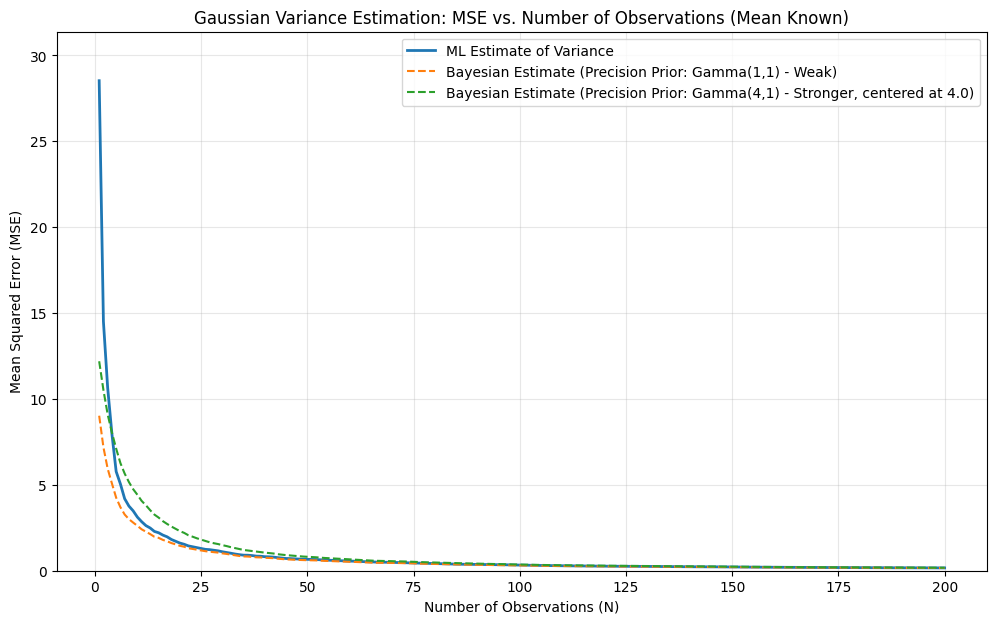

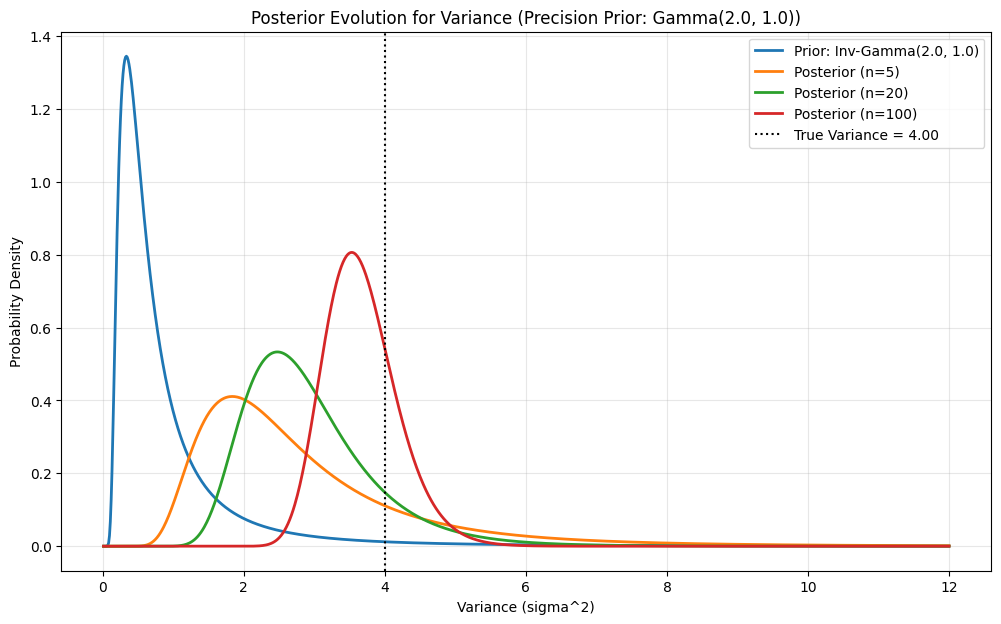

In [ ]:
# True parameters
known_mean = 5.0
true_variance = 4.0
true_precision = 1 / true_variance

n_max = 200
n_values = np.arange(1, n_max + 1)
n_trials = 1000

# Priors for the PRECISION (1/variance), which follow a Gamma distribution.
# Gamma(alpha, beta), where alpha is the shape and beta is the rate.
priors = [
    {'alpha': 1, 'beta': 1, 'label': 'Precision Prior: Gamma(1,1) - Weak'},
    {'alpha': 4, 'beta': 1, 'label': 'Precision Prior: Gamma(4,1) - Stronger, centered at 4.0'}
]

# MSE initialization
mse_ml = np.zeros(n_max)
mse_bayesian = [np.zeros(n_max) for _ in priors]

# Trial loop
for trial in range(n_trials):
    data = np.random.normal(known_mean, np.sqrt(true_variance), n_max)

    for i, n in enumerate(n_values):
        squared_deviations = np.sum((data[:n] - known_mean) ** 2)

        # Calculate ML estimate for variance
        var_ml = squared_deviations / n

        for j, prior in enumerate(priors):
            # Posterior parameters for the precision (Gamma distribution)
            alpha_post = prior['alpha'] + n / 2
            beta_post = prior['beta'] + squared_deviations / 2

            # The posterior for the variance is Inverse-Gamma(alpha_post, beta_post).
            # We use the mode of the posterior distribution as the Bayesian estimate,
            # which is beta_post / (alpha_post + 1).
            var_bayesian = beta_post / (alpha_post + 1)

            # Accumulate squared errors
            mse_bayesian[j][i] += (var_bayesian - true_variance) ** 2

        # Accumulate squared error for ML estimate
        mse_ml[i] += (var_ml - true_variance) ** 2

# Average over trials to get MSE
mse_ml /= n_trials
for j in range(len(priors)):
    mse_bayesian[j] /= n_trials


# Plots


# Plot MSE comparison
plt.figure(figsize=(12, 7))
plt.plot(n_values, mse_ml, label='ML Estimate of Variance', linewidth=2)
for j, prior in enumerate(priors):
    plt.plot(n_values, mse_bayesian[j], label=f"Bayesian Estimate ({prior['label']})", linestyle='--')

plt.xlabel('Number of Observations (N)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Gaussian Variance Estimation: MSE vs. Number of Observations (Mean Known)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, max(np.max(mse_ml), np.max(mse_bayesian[0])) * 1.1)
plt.show()

# Plot

# Prior for the precision: Gamma(alpha0, beta0)
alpha_prior, beta_prior = 2.0, 1.0
n_obs_list = [0, 5, 20, 100]

# Generate new data for this plot
data = np.random.normal(known_mean, np.sqrt(true_variance), max(n_obs_list))

x_var = np.linspace(0.01, 12.0, 1000) # x-axis for variance plots
plt.figure(figsize=(12, 7))

for n_obs in n_obs_list:
    if n_obs == 0:
        # Prior distribution for the variance is Inv-Gamma(α₀, β₀)
        alpha_post = alpha_prior
        beta_post = beta_prior
        label = f'Prior: Inv-Gamma({alpha_prior}, {beta_prior})'
    else:
        # Posterior distribution for the variance is Inv-Gamma(αₙ, βₙ)
        squared_deviations = np.sum((data[:n_obs] - known_mean) ** 2)
        alpha_post = alpha_prior + n_obs / 2
        beta_post = beta_prior + squared_deviations / 2
        label = f'Posterior (n={n_obs})'

    # The PDF for the variance σ² follows the Inverse Gamma distribution
    pdf = stats.invgamma.pdf(x_var, a=alpha_post, scale=beta_post)
    plt.plot(x_var, pdf, label=label, linewidth=2)

plt.axvline(true_variance, color='black', linestyle=':', label=f'True Variance = {true_variance:.2f}')
plt.xlabel('Variance (sigma^2)')
plt.ylabel('Probability Density')
plt.title(f'Posterior Evolution for Variance (Precision Prior: Gamma({alpha_prior}, {beta_prior}))')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## Stretch Goal 1

In [ ]:
# True parameters
true_mean = 5.0
known_variance = 10.0
n_trials = 50

# Prior parameters (estimates)
prior_mean = 0.0
prior_variance = 10.0

# Generate data

data = np.random.normal(true_mean, np.sqrt(known_variance), n_trials)

# List to store filenames of saved frames
filenames = []
n_frames = np.arange(1, n_trials + 1, 1)

# Create a figure for the animation
fig, ax = plt.subplots(figsize=(10, 6))
x = np.linspace(true_mean - 5, true_mean + 5, 1000)
pdf_prior = stats.norm.pdf(x, prior_mean, np.sqrt(prior_variance))
ax.plot(x, pdf_prior, label='Prior (n=0)', linewidth=2, linestyle=':')
ax.axvline(true_mean, color='black', linestyle='--', label=f'True μ = {true_mean}')

# generate frames
for i, n_obs in enumerate(n_frames):
    # Calculate sample mean
    sample_mean = np.mean(data[:n_obs])

    # Calculate posterior parameters
    prior_precision = 1 / prior_variance
    data_precision = n_obs / known_variance
    posterior_precision = prior_precision + data_precision
    posterior_variance = 1 / posterior_precision
    prior_mean_weighted = prior_mean * prior_precision
    data_mean_weighted = sample_mean * data_precision
    posterior_mean = (prior_mean_weighted + data_mean_weighted) / posterior_precision

    # Calculate and plot the posterior PDF
    pdf_posterior = stats.norm.pdf(x, posterior_mean, np.sqrt(posterior_variance))

    # Clear previous posterior line if it exists to avoid clutter
        if len(ax.lines) > 2:
            ax.lines[-1].remove()

    # Plot the current posterior
    ax.plot(
        x,
        pdf_posterior,
        color='red',
        linewidth=2,
        label=f'Posterior (n={n_obs})' if i==0 else "",
    )

    # Update title and legend
    ax.set_title(f'Posterior Evolution: N(0,10) Prior \n(Variance Known with n={n_obs} Observations')
    ax.set_xlabel('Mean (mew)')
    ax.set_ylabel('Probability Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Save the current plot as a PNG image
    filename = f'/tmp/frame_{n_obs:04d}.png'
    plt.savefig(filename)
    filenames.append(filename)

plt.close(fig) # Close the figure to free up memory

/tmp/ipython-input-3386990360.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF created successfully!


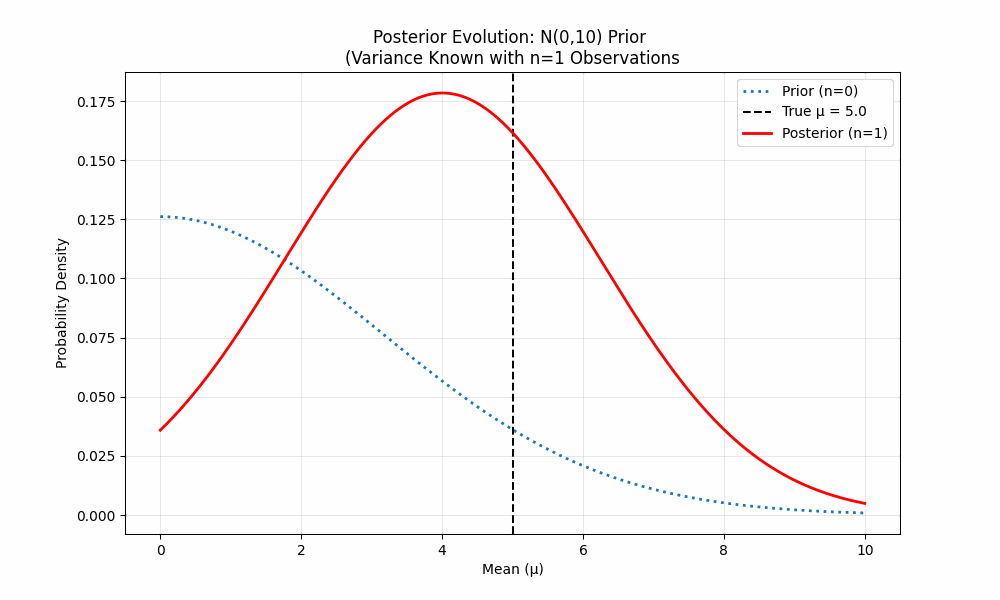

In [ ]:
from IPython.display import Image, display
# Create the GIF
with imageio.get_writer('posterior_evolution.gif', mode='I', duration=0.05) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

print("GIF created successfully!")
display(Image(filename='posterior_evolution.gif'))

# Stretch Goal 2

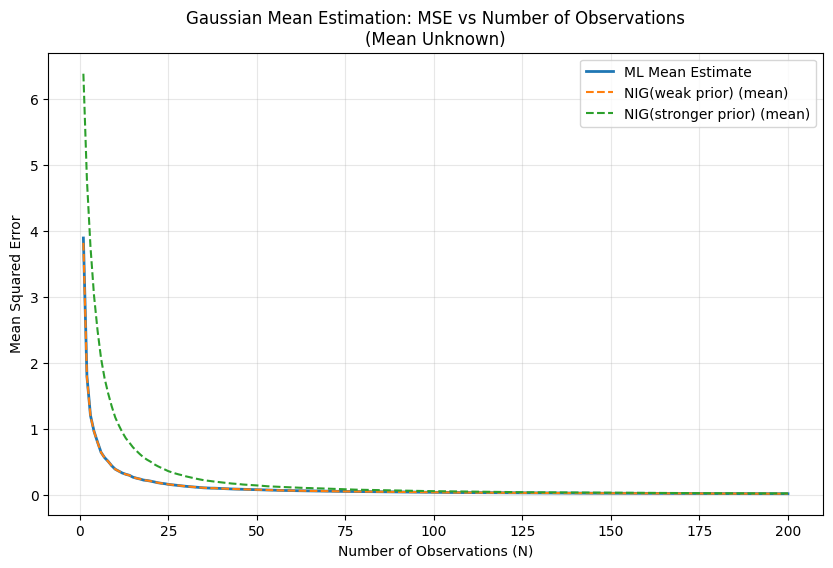

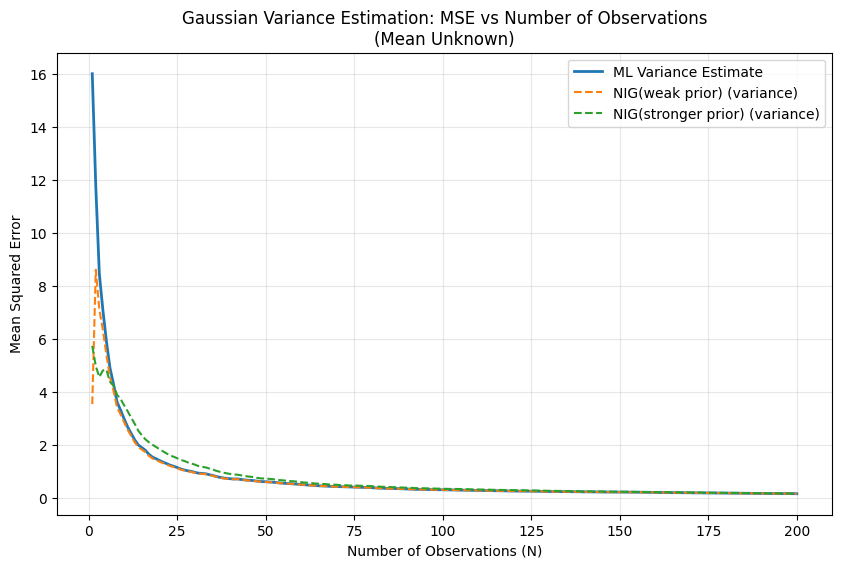

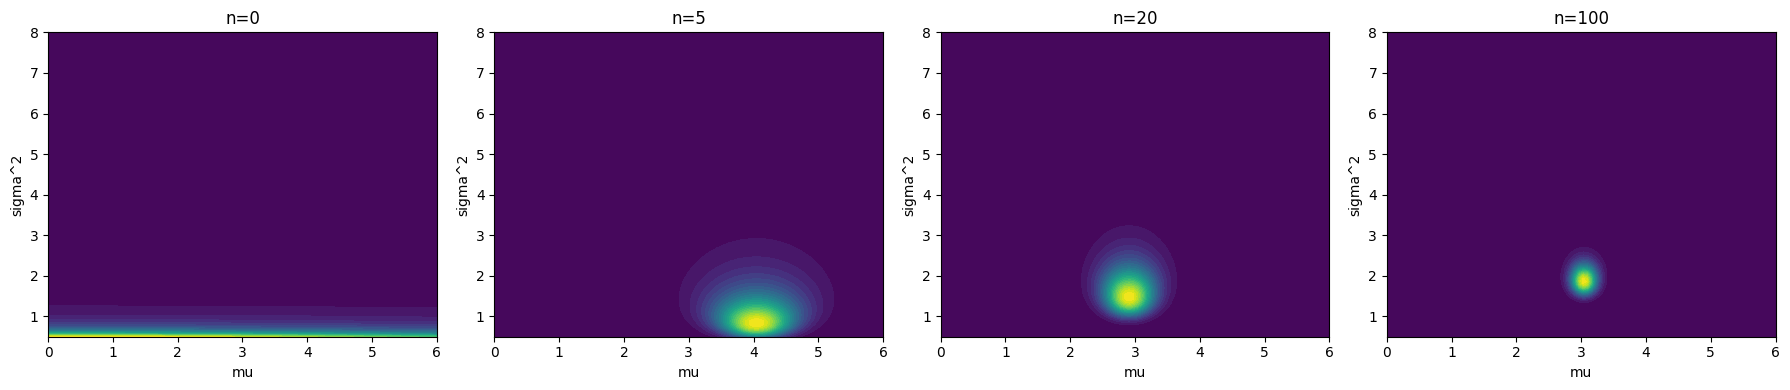

In [ ]:
# True parameters
true_mean = 3.0
true_variance = 4.0

n_max = 200
n_values = np.arange(1, n_max + 1)
n_trials = 1000

priors = [
    {'mu0': 0.0, 'beta': 0.01, 'a': 1, 'b': 1, 'label': 'NIG(weak prior)'},
    {'mu0': 0.0, 'beta': 5.0,  'a': 3, 'b': 2, 'label': 'NIG(stronger prior)'}
]

# MSE initialization (for mean and variance separately)
mse_ml_mean = np.zeros(n_max)
mse_ml_var = np.zeros(n_max)
mse_bayes_mean = [np.zeros(n_max) for _ in priors]
mse_bayes_var = [np.zeros(n_max) for _ in priors]

# Trial loop
for trial in range(n_trials):
    data = np.random.normal(true_mean, np.sqrt(true_variance), n_max)

    for i, n in enumerate(n_values):

        sample_mean = np.mean(data[:n])
        sample_var = np.var(data[:n], ddof=0)  # ML (biased) estimate

        # ML errors
        mse_ml_mean[i] += (sample_mean - true_mean)**2
        mse_ml_var[i]  += (sample_var - true_variance)**2

        for j, prior in enumerate(priors):

            mu0, beta0, a0, b0 = prior['mu0'], prior['beta'], prior['a'], prior['b']

            beta_n = beta0 + n
            mu_n = (beta0 * mu0 + n * sample_mean) / beta_n
            a_n = a0 + n/2
            ssq = np.sum((data[:n] - sample_mean)**2)
            b_n = b0 + 0.5*ssq + (beta0*n/(2*beta_n))*(sample_mean - mu0)**2

            # Bayesian estimates (posterior means)
            mean_bayes = mu_n
            var_bayes = b_n / (a_n - 1) if a_n > 1 else np.inf

            mse_bayes_mean[j][i] += (mean_bayes - true_mean)**2
            mse_bayes_var[j][i]  += (var_bayes - true_variance)**2

# Average over trials to get MSE
mse_ml_mean /= n_trials
mse_ml_var /= n_trials
for j in range(len(priors)):
    mse_bayes_mean[j] /= n_trials
    mse_bayes_var[j] /= n_trials

plt.figure(figsize=(10, 6))
plt.plot(n_values, mse_ml_mean, label='ML Mean Estimate', linewidth=2)
for j, prior in enumerate(priors):
    plt.plot(n_values, mse_bayes_mean[j], label=priors[j]['label'] + ' (mean)', linestyle='--')
plt.xlabel('Number of Observations (N)')
plt.ylabel('Mean Squared Error')
plt.title('Gaussian Mean Estimation: MSE vs Number of Observations\n(Mean Unknown)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot MSE for variance estimation
plt.figure(figsize=(10, 6))
plt.plot(n_values, mse_ml_var, label='ML Variance Estimate', linewidth=2)
for j, prior in enumerate(priors):
    plt.plot(n_values, mse_bayes_var[j], label=priors[j]['label'] + ' (variance)', linestyle='--')
plt.xlabel('Number of Observations (N)')
plt.ylabel('Mean Squared Error')
plt.title('Gaussian Variance Estimation: MSE vs Number of Observations\n(Mean Unknown)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Posterior evolution heatmap
mu0, beta0, a0, b0 = 0.0, 0.01, 2.0, 2.0
n_obs_list = [0, 5, 20, 100]
data = np.random.normal(true_mean, np.sqrt(true_variance), max(n_obs_list))

mu_grid = np.linspace(0, 6, 100)
var_grid = np.linspace(0.5, 8, 100)
MU, VAR = np.meshgrid(mu_grid, var_grid)

fig, axes = plt.subplots(1, len(n_obs_list), figsize=(18, 4))
for ax, n_obs in zip(axes, n_obs_list):
    if n_obs == 0:
        mu_n, beta_n, a_n, b_n = mu0, beta0, a0, b0
    else:
        sample_mean = np.mean(data[:n_obs])
        ssq = np.sum((data[:n_obs] - sample_mean)**2)
        beta_n = beta0 + n_obs
        mu_n = (beta0*mu0 + n_obs*sample_mean) / beta_n
        a_n = a0 + n_obs/2
        b_n = b0 + 0.5*ssq + (beta0*n_obs/(2*beta_n))*(sample_mean - mu0)**2

    # Evaluate NIG pdf on grid
    Z = stats.norm.pdf(MU, loc=mu_n, scale=np.sqrt(VAR/beta_n)) * stats.invgamma.pdf(VAR, a=a_n, scale=beta_n)
    Z /= Z.max()  # normalize for visualization
    ax.contourf(MU, VAR, Z, levels=30, cmap="viridis")
    ax.set_title(f"n={n_obs}")
    ax.set_xlabel("mu")
    ax.set_ylabel("sigma^2")

plt.tight_layout()
plt.show()